# CNN 3 Classes
ECG Multi-class Classification using CNN
Overview
Multi-class deep learning model for classifying cardiac conditions from 15-lead ECG signals using ResNet-based 1D CNN architecture.
Dataset

Source: PTB Diagnostic ECG Database
Samples: 15-lead ECG recordings (5000 time points per signal)
Classes: 3 cardiac conditions after filtering

Healthy Controls
Myocardial Infarction
Bundle Branch Block


Excluded: Myocarditis, Valvular heart disease, Cardiomyopathy/Heart failure, Dysrhythmia
Split: Stratified train/validation/test split

Key Modifications from Binary Model

Multi-class output: Softmax activation instead of sigmoid
Loss function: Categorical crossentropy instead of focal loss
Label encoding: One-hot encoding for multiple classes
SMOTE: Adapted for multi-class imbalance handling
Metrics: Multi-class precision, recall, F1-score per class

Key Techniques

Class Balancing: Multi-class SMOTE oversampling
Data Augmentation: Noise injection, amplitude scaling, temporal shifts, mixup
Architecture: ResNet with residual blocks (64→128→256→512 filters) + BatchNorm + Dropout
Training: Adam optimizer, learning rate scheduling, early stopping (100 epochs max)
Regularization: L2 regularization, dropout, batch normalization

Model Performance Metrics
Accuracy | Precision | Recall | F1-Score | Confusion Matrix (per class)
Technologies
TensorFlow/Keras | NumPy | Pandas | scikit-learn | imbalanced-learn | wfdb


Loading ECG data...
Found 290 patient folders
Processed 50/290 patients... Loaded: 162, Skipped: 0
Processed 100/290 patients... Loaded: 311, Skipped: 0
Processed 150/290 patients... Loaded: 340, Skipped: 27
Processed 200/290 patients... Loaded: 382, Skipped: 54
Processed 250/290 patients... Loaded: 431, Skipped: 68

Total files found: 549
Successfully loaded: 465
Excluded (Myocarditis & Valvular): 46
Skipped (other reasons): 38
Success rate: 84.7%

X shape: (465, 5000, 15)
y shape: (465,)

Label distribution:
  Bundle branch block: 17 (3.7%)
  Healthy controls: 80 (17.2%)
  Myocardial infarction: 368 (79.1%)

Number of classes: 3
Classes: ['Bundle branch block' 'Healthy controls' 'Myocardial infarction']
One-hot encoded labels shape: (465, 3)

SPLITTING DATA
Train set: 297 samples
  Bundle branch block: 11 (3.7%)
  Healthy controls: 51 (17.2%)
  Myocardial infarction: 235 (79.1%)

Validation set: 75 samples
  Bundle branch block: 3 (4.0%)
  Healthy controls: 13 (17.3%)
  Myocardial in

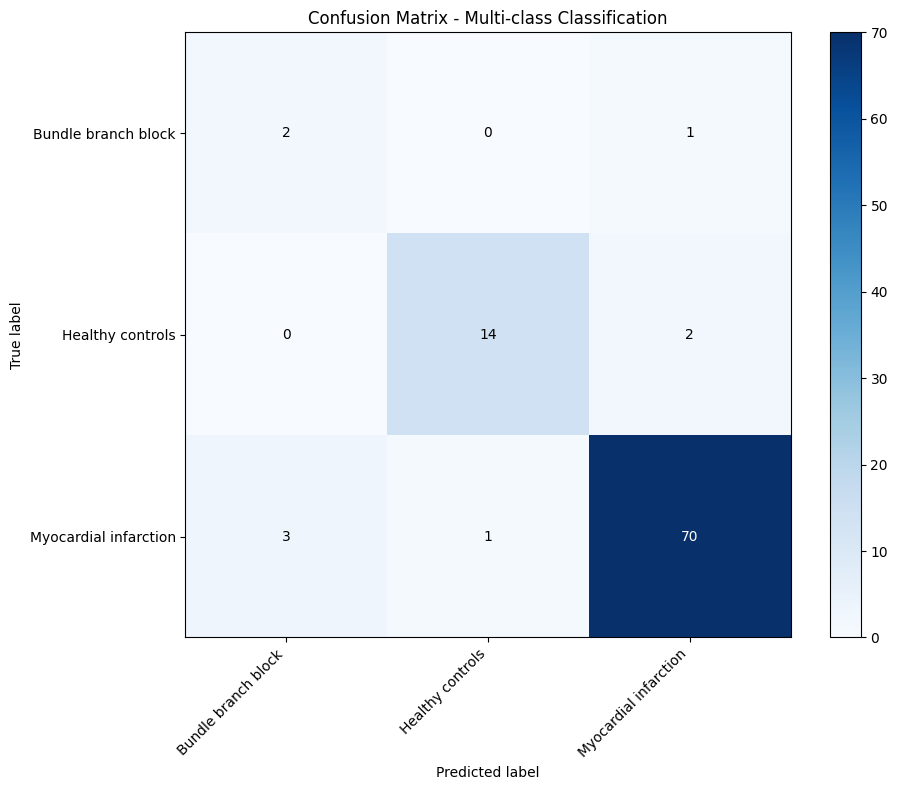


Model and results saved!
- Model: models/best_model_multiclass.keras
- Confusion Matrix: confusion_matrix_multiclass.png


In [ ]:


import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import time
import warnings
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, BatchNormalization, Add, Activation
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

# ============================================================================
# CONFIGURATION
# ============================================================================
base_dir = 'Data/ptb-diagnostic-ecg-database'
output_dir = 'Data/processed_signals'
os.makedirs(output_dir, exist_ok=True)

SIGNAL_LENGTH = 5000
NUM_LEADS = 15

# Classes to EXCLUDE
EXCLUDED_CLASSES = ['Myocarditis', 'Valvular heart disease','Cardiomyopathy/Heart failure','Cardiomyopathy/Heart failure','Dysrhythmia']

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def to_key(s):
    s = s.strip('# ').lower()
    s = s.replace('(localization)','localization').replace('(at rest)','at_rest').replace('(load)','load')
    return re.sub(r'[^a-z0-9]+','_',s).strip('_')

def parse_comments(comments):
    d = {}
    for c in comments or []:
        if ':' in c:
            k, v = c.split(':', 1)
            d[to_key(k)] = v.strip()
    return d

def map_primary_label(meta):
    raw = (meta.get('reason_for_admission') or meta.get('diagnose') or '').lower()
    raw = raw.replace('heartfailure','heart failure').replace('arrhythmia','dysrhythmia')
    if 'healthy control' in raw: return 'Healthy controls'
    if 'myocardial infarction' in raw: return 'Myocardial infarction'
    if 'cardiomyopathy' in raw or 'heart failure' in raw: return 'Cardiomyopathy/Heart failure'
    if 'bundle branch block' in raw: return 'Bundle branch block'
    if 'dysrhythmia' in raw: return 'Dysrhythmia'
    if 'myocardial hypertrophy' in raw: return 'Myocardial hypertrophy'
    if 'valvular heart disease' in raw: return 'Valvular heart disease'
    if 'myocarditis' in raw: return 'Myocarditis'
    return 'Other'

def load_ecg_safely(record_path, target_length=5000):
    try:
        record = wfdb.rdrecord(record_path)
        signal = record.p_signal
        
        if signal is None or len(signal) == 0:
            return None, None
        if signal.shape[1] != NUM_LEADS:
            if signal.shape[1] < NUM_LEADS:
                padding = NUM_LEADS - signal.shape[1]
                signal = np.pad(signal, ((0, 0), (0, padding)), mode='edge')
            else:
                signal = signal[:, :NUM_LEADS]
        
        if len(signal) >= target_length:
            signal = signal[:target_length, :]
        else:
            padding = target_length - len(signal)
            signal = np.pad(signal, ((0, padding), (0, 0)), mode='edge')
        
        # Normalization
        for i in range(signal.shape[1]):
            mean = signal[:, i].mean()
            std = signal[:, i].std()
            if std > 0:
                signal[:, i] = (signal[:, i] - mean) / std
            else:
                signal[:, i] = 0
        
        meta = parse_comments(record.comments)
        return signal, meta
    
    except Exception as e:
        return None, None

# ============================================================================
# LOAD AND PREPROCESS DATA
# ============================================================================

print("Loading ECG data...")
all_signals = []
all_labels = []
all_metadata = []

patient_folders = sorted([f for f in os.listdir(base_dir) if f.startswith('patient')])
total_files = 0
loaded_files = 0
skipped_files = 0
excluded_files = 0

print(f"Found {len(patient_folders)} patient folders")

for idx, patient_folder in enumerate(patient_folders):
    patient_path = os.path.join(base_dir, patient_folder)
    
    if not os.path.isdir(patient_path):
        continue
    
    hea_files = [f for f in os.listdir(patient_path) if f.endswith('.hea')]
    total_files += len(hea_files)
    
    for hea_file in hea_files:
        record_name = hea_file.replace('.hea', '')
        record_path = os.path.join(patient_path, record_name)
        
        signal, meta = load_ecg_safely(record_path, target_length=SIGNAL_LENGTH)
        
        if signal is None:
            skipped_files += 1
            continue
        
        primary_label = map_primary_label(meta)
        
        # Skip "Other" category
        if primary_label == 'Other':
            skipped_files += 1
            continue
        
        # NEW: Skip excluded classes (Myocarditis and Valvular heart disease)
        if primary_label in EXCLUDED_CLASSES:
            excluded_files += 1
            skipped_files += 1
            continue
        
        all_signals.append(signal)
        all_labels.append(primary_label)
        all_metadata.append(meta)
        loaded_files += 1
    
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(patient_folders)} patients... Loaded: {loaded_files}, Skipped: {skipped_files}")

print(f"\nTotal files found: {total_files}")
print(f"Successfully loaded: {loaded_files}")
print(f"Excluded (Myocarditis & Valvular): {excluded_files}")
print(f"Skipped (other reasons): {skipped_files - excluded_files}")
print(f"Success rate: {loaded_files/total_files*100:.1f}%")

# Convert to arrays
X = np.array(all_signals)
y_multi = np.array(all_labels)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y_multi.shape}")

# Show label distribution
print(f"\nLabel distribution:")
unique, counts = np.unique(y_multi, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} ({count/len(y_multi)*100:.1f}%)")

# ============================================================================
# ENCODE LABELS FOR MULTI-CLASS CLASSIFICATION
# ============================================================================

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_multi)
num_classes = len(label_encoder.classes_)

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Convert to one-hot encoding
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

print(f"One-hot encoded labels shape: {y_categorical.shape}")

# Save processed data
np.save(os.path.join(output_dir, 'X_signals_15lead_multiclass.npy'), X)
np.save(os.path.join(output_dir, 'y_multiclass_encoded.npy'), y_encoded)
np.save(os.path.join(output_dir, 'y_multiclass_categorical.npy'), y_categorical)
np.save(os.path.join(output_dir, 'y_multiclass_labels.npy'), y_multi)

# Save label encoder classes
np.save(os.path.join(output_dir, 'label_classes.npy'), label_encoder.classes_)

# ============================================================================
# TRAIN/VAL/TEST SPLIT
# ============================================================================

print("\n" + "="*50)
print("SPLITTING DATA")
print("="*50)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_categorical,
    test_size=0.2,
    stratify=y_encoded,  # Use encoded labels for stratification
    random_state=42
)

# Also split the encoded labels for later use
y_trainval_encoded = label_encoder.transform(label_encoder.inverse_transform(np.argmax(y_trainval, axis=1)))
y_test_encoded = label_encoder.transform(label_encoder.inverse_transform(np.argmax(y_test, axis=1)))

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    stratify=y_trainval_encoded,
    random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(np.argmax(y_train, axis=1) == i)
    print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nValidation set: {X_val.shape[0]} samples")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(np.argmax(y_val, axis=1) == i)
    print(f"  {class_name}: {count} ({count/len(y_val)*100:.1f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(np.argmax(y_test, axis=1) == i)
    print(f"  {class_name}: {count} ({count/len(y_test)*100:.1f}%)")

# ============================================================================
# SMOTE FOR CLASS IMBALANCE (Multi-class)
# ============================================================================

print("\n" + "="*50)
print("APPLYING SMOTE FOR CLASS BALANCING")
print("="*50)

# Convert categorical back to encoded for SMOTE
y_train_encoded = np.argmax(y_train, axis=1)

print("\nBefore SMOTE:")
unique, counts = np.unique(y_train_encoded, return_counts=True)
for label, count in zip(unique, counts):
    class_name = label_encoder.classes_[label]
    print(f"  {class_name}: {count}")

# Reshape for SMOTE
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=min(3, min(counts)-1))
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_2d, y_train_encoded)

# Reshape back
X_train_balanced = X_train_balanced.reshape(-1, SIGNAL_LENGTH, NUM_LEADS)

# Convert back to categorical
y_train_balanced = to_categorical(y_train_balanced, num_classes=num_classes)

print("\nAfter SMOTE:")
unique, counts = np.unique(np.argmax(y_train_balanced, axis=1), return_counts=True)
for label, count in zip(unique, counts):
    class_name = label_encoder.classes_[label]
    print(f"  {class_name}: {count}")

print(f"\nBalanced training set shape: {X_train_balanced.shape}")

# ============================================================================
# DATA AUGMENTATION
# ============================================================================

def augment_ecg_signal(signal):
    augmented = signal.copy()
    
    if np.random.random() < 0.6:
        noise_level = np.random.uniform(0.02, 0.05)
        noise = np.random.normal(0, noise_level, signal.shape)
        augmented += noise
    
    if np.random.random() < 0.6:
        scale_factor = np.random.uniform(0.8, 1.2)
        augmented *= scale_factor
    
    if np.random.random() < 0.4:
        shift = np.random.randint(-150, 150)
        augmented = np.roll(augmented, shift, axis=0)
    
    if np.random.random() < 0.4:
        time = np.arange(len(signal))
        frequency = np.random.uniform(0.001, 0.003)
        amplitude = np.random.uniform(0.05, 0.15)
        baseline = amplitude * np.sin(2 * np.pi * frequency * time)
        augmented += baseline[:, np.newaxis]
    
    if np.random.random() < 0.25:
        num_flips = np.random.randint(1, 5)
        flip_leads = np.random.choice(signal.shape[1], size=num_flips, replace=False)
        augmented[:, flip_leads] *= -1
    
    if np.random.random() < 0.3:
        crop_size = np.random.randint(4500, 5000)
        start = np.random.randint(0, len(signal) - crop_size)
        cropped = augmented[start:start+crop_size]
        pad_before = np.random.randint(0, 5000 - crop_size + 1)
        pad_after = 5000 - crop_size - pad_before
        augmented = np.pad(cropped, ((pad_before, pad_after), (0, 0)), mode='edge')
    
    if np.random.random() < 0.3:
        time = np.arange(len(signal))
        freq = np.random.choice([50, 60])
        amplitude = np.random.uniform(0.03, 0.08)
        interference = amplitude * np.sin(2 * np.pi * freq * time / 1000)
        augmented += interference[:, np.newaxis]
    
    if np.random.random() < 0.2:
        num_dropout = np.random.randint(1, 3)
        dropout_leads = np.random.choice(signal.shape[1], size=num_dropout, replace=False)
        augmented[:, dropout_leads] = 0
    
    if np.random.random() < 0.25:
        warp_factor = np.random.uniform(0.95, 1.05)
        indices = np.arange(len(signal))
        warped_indices = (indices * warp_factor).astype(int)
        warped_indices = np.clip(warped_indices, 0, len(signal) - 1)
        augmented = augmented[warped_indices]
    
    return augmented

# ============================================================================
# DATA GENERATOR
# ============================================================================

import tensorflow as tf

class ECGDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, augment=False, mixup_alpha=0.2):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mixup_alpha = mixup_alpha
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        X_batch = self.X[batch_indices].copy()
        y_batch = self.y[batch_indices].copy()
        
        if self.augment:
            X_batch = np.array([augment_ecg_signal(x) for x in X_batch])
            
            if np.random.random() < 0.3 and len(X_batch) > 1:
                lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                shuffle_indices = np.random.permutation(len(X_batch))
                X_batch = lam * X_batch + (1 - lam) * X_batch[shuffle_indices]
                y_batch = lam * y_batch + (1 - lam) * y_batch[shuffle_indices]
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators
train_gen = ECGDataGenerator(
    X_train_balanced, y_train_balanced,
    batch_size=32,
    shuffle=True,
    augment=True,
    mixup_alpha=0.2
)

val_gen = ECGDataGenerator(
    X_val, y_val,
    batch_size=32,
    shuffle=False,
    augment=False
)

test_gen = ECGDataGenerator(
    X_test, y_test,
    batch_size=32,
    shuffle=False,
    augment=False
)

# ============================================================================
# MODEL ARCHITECTURE (Modified for Multi-class)
# ============================================================================

def residual_block(x, filters, kernel_size=3, dropout_rate=0.3):
    shortcut = x
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

def create_resnet_ecg_model(input_shape, num_classes):
    """
    Modified for multi-class classification
    Changed: num_classes parameter and final activation to 'softmax'
    """
    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, 7, padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.3)(x)
    
    x = residual_block(x, 64, kernel_size=5, dropout_rate=0.3)
    x = MaxPooling1D(3)(x)
    
    x = residual_block(x, 128, kernel_size=5, dropout_rate=0.3)
    x = residual_block(x, 128, kernel_size=5, dropout_rate=0.3)
    x = MaxPooling1D(3)(x)
    
    x = residual_block(x, 256, kernel_size=3, dropout_rate=0.4)
    x = residual_block(x, 256, kernel_size=3, dropout_rate=0.4)
    x = MaxPooling1D(3)(x)
    
    x = residual_block(x, 512, kernel_size=3, dropout_rate=0.4)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    
    # CHANGED: softmax activation for multi-class
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# ============================================================================
# COMPILE AND TRAIN MODEL
# ============================================================================

print("\n" + "="*50)
print("BUILDING AND COMPILING MODEL")
print("="*50)

# Build model
model = create_resnet_ecg_model(
    input_shape=(SIGNAL_LENGTH, NUM_LEADS),
    num_classes=num_classes
)

# Compute class weights
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.arange(num_classes),
    y=np.argmax(y_train_balanced, axis=1)
)
class_weights = dict(enumerate(class_weights_array))

print(f"\nClass weights:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {class_weights[i]:.3f}")

# Compile model with categorical crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # CHANGED: for multi-class
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'models/best_model_multiclass.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train
print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ============================================================================
# EVALUATE MODEL
# ============================================================================

print("\n" + "="*50)
print("EVALUATING MODEL")
print("="*50)

# Predictions
y_pred_proba = model.predict(test_gen)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Multi-class Classification')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, label_encoder.classes_)

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix_multiclass.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel and results saved!")
print(f"- Model: models/best_model_multiclass.keras")
print(f"- Confusion Matrix: confusion_matrix_multiclass.png")